<a href="https://colab.research.google.com/github/anoldKupara/Machine-Learning-Course/blob/main/Titanic_Disaster_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Machine Learning Assignment 3
# Predict survival on the Titanic
# Defining the problem statement
# Collecting the data
# Exploratory data analysis
# Feature engineering
# Modelling and Testing

In [41]:
# 1. Defining the problem statement
# with using titanic dataset what sorts of people were likely survive we will apply the tools of machine learning to predict which passengers survived the Titanic tragedy.

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
sns.set()

In [42]:
#2. Collecting the data¶

data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/data/train.csv")
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/test.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [43]:
# Cleaning the dataset by removing all null variable
# fillna with median
# fillna with mean

#cleaning train data
data["Age"].fillna(data.Age.mean(), inplace=True)
data["Fare"] = data["Fare"].fillna(data["Fare"].median())
data["Embarked"] = data["Embarked"].fillna('S')
data["Cabin"] = data["Cabin"].fillna(0)
#data.isnull().sum()
#cleaning test data
test["Age"].fillna(test.Age.mean(), inplace=True)
test["Fare"] = test["Fare"].fillna(test["Fare"].median())
test["Embarked"] = test["Embarked"].fillna('S')
test["Cabin"] = test["Cabin"].fillna(0)
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [44]:
# 3. Exploratory data analysis
# Set of tables
# Pclass
# Age
# Gender

data.groupby('Sex').agg('mean')[['Survived']].reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [45]:
data.groupby('Pclass').agg('mean')[['Survived']].reset_index()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [46]:
# So it clearly seems that,The survival of the people belong to 3rd class is very least. It looks like ...

# 63% first class passenger survived titanic tragedy, while
# 48% second class and
# only 24% third class passenger survived. It is true since there were a lot more third class passengers than first and second.

In [47]:
#creating the age table 
bins= [0,10,20,30,40,50,60,70,80,90]
data['agebin']= pd.cut(data['Age'],bins)
data[data['Survived']==1]['agebin'].value_counts().sort_index()
#data.groupby('agebin').agg('mean')[['Survived']]
#data.groupby('agebin').agg('mean')[['Survived']].plot(kind='bar')

(0, 10]      38
(10, 20]     44
(20, 30]    136
(30, 40]     69
(40, 50]     33
(50, 60]     17
(60, 70]      4
(70, 80]      1
(80, 90]      0
Name: agebin, dtype: int64

In [48]:
def tables(feature):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    print(df)

In [49]:
tables('Sex')

          female  male
Survived     233   109
Dead          81   468


In [50]:
tables('Pclass')

            1   2    3
Survived  136  87  119
Dead       80  97  372


In [51]:
tables('agebin')

          (0, 10]  (10, 20]  (20, 30]  ...  (60, 70]  (70, 80]  (80, 90]
Survived       38        44       136  ...         4         1         0
Dead           26        71       271  ...        13         4         0

[2 rows x 9 columns]


In [52]:
tables('SibSp')

              0      1     2     3     4    5    8
Survived  210.0  112.0  13.0   4.0   3.0  NaN  NaN
Dead      398.0   97.0  15.0  12.0  15.0  5.0  7.0


In [53]:
tables('Embarked')

            S   C   Q
Survived  219  93  30
Dead      427  75  47


In [54]:
# Feature engineering
# Encoding the categorical values into numerical values
# by using map function #### Generating new features like:
# The length of the name -- this could pertain to how rich the person was, and therefore their position in the Titanic.
# The total number of people in a family (SibSp + Parch).
# This can improve our predictions about survival chance based on social position or family members aboard who helped.

In [55]:
#Encoding name feature

#Extracting title from the name in train
name = pd.Series(data['Name'])
for dataset in data:
    dataset = name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
#Extracting title from the name in test
name = pd.Series(test['Name'])
for dataset in data:
    dataset = name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [56]:
#converting categorical into numerical values in train
data['title']=pd.DataFrame(dataset)
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
data['title']=data['title'].map(title_mapping)

#converting categorical into numerical values in test
test['title']=pd.DataFrame(dataset)
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
test['title']=test['title'].map(title_mapping)

In [57]:
#visualize the title
tables('title')

          0.0  1.0  2.0  3.0
Survived  101   27   25   10
Dead      139   51   47   18


In [58]:
#Encoding sex feature

data.loc[data["Sex"] == "male", "Sex"] = 0
data.loc[data["Sex"] == "female", "Sex"] = 1

test.loc[test["Sex"] == "male", "Sex"] = 0
test.loc[test["Sex"] == "female", "Sex"] = 1

In [59]:
#Encoding embarked feature

data["Embarked"] = data["Embarked"].fillna('S')
data.loc[data["Embarked"] == "S", "Embarked"] = 0
data.loc[data["Embarked"] == "C", "Embarked"] = 1
data.loc[data["Embarked"] == "Q", "Embarked"] = 2

test["Embarked"] = test["Embarked"].fillna('S')
test.loc[test["Embarked"] == "S", "Embarked"] = 0
test.loc[test["Embarked"] == "C", "Embarked"] = 1
test.loc[test["Embarked"] == "Q", "Embarked"] = 2

In [60]:
#Encoding cabin feature

for dataset in data:
    data['Cabin'] = data['Cabin'].str[:1]
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
    
data.loc[data["Cabin"] == "A", "Cabin"] = 0
data.loc[data["Cabin"] == "B", "Cabin"] = 0.4
data.loc[data["Cabin"] == "C", "Cabin"] = 0.8
data.loc[data["Cabin"] == "D", "Cabin"] = 1.2
data.loc[data["Cabin"] == "E", "Cabin"] = 1.6
data.loc[data["Cabin"] == "F", "Cabin"] = 2
data.loc[data["Cabin"] == "G", "Cabin"] = 2.4
data.loc[data["Cabin"] == "T", "Cabin"] = 2.8

for dataset in test:
    test['Cabin'] = test['Cabin'].str[:1]
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
    
test.loc[test["Cabin"] == "A", "Cabin"] = 0
test.loc[test["Cabin"] == "B", "Cabin"] = 0.4
test.loc[test["Cabin"] == "C", "Cabin"] = 0.8
test.loc[test["Cabin"] == "D", "Cabin"] = 1.2
test.loc[test["Cabin"] == "E", "Cabin"] = 1.6
test.loc[test["Cabin"] == "F", "Cabin"] = 2
test.loc[test["Cabin"] == "G", "Cabin"] = 2.4
test.loc[test["Cabin"] == "T", "Cabin"] = 2.8
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,892,3,"Kelly, Mr. James",0,34.50000,0,0,330911,7.8292,NaN,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,363272,7.0000,NaN,0,2
2,894,2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,240276,9.6875,NaN,2,0
3,895,3,"Wirz, Mr. Albert",0,27.00000,0,0,315154,8.6625,NaN,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,3101298,12.2875,NaN,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,30.27259,0,0,A.5. 3236,8.0500,NaN,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,PC 17758,108.9000,0.8,1,3
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,0
416,1308,3,"Ware, Mr. Frederick",0,30.27259,0,0,359309,8.0500,NaN,0,0


In [61]:
#combining sibsp+parch features

data["FamilySize"] = data["SibSp"] + data["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]

In [62]:
# rank the variable according to the correlation between itself and survival.
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,title,FamilySize
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658,-0.000245,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,-0.062270,0.016639
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,0.114195,0.065997
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.017431,-0.248512
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,0.047878,0.890712
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,-0.027594,0.783111
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,-0.085811,0.217138
title,-0.000245,-0.062270,0.114195,0.017431,0.047878,-0.027594,-0.085811,1.000000,0.021487
FamilySize,-0.040143,0.016639,0.065997,-0.248512,0.890712,0.783111,0.217138,0.021487,1.000000


In [63]:
#droping feature (?)

features_drop = ['Ticket', 'SibSp', 'Parch',"Name",'agebin']
data = data.drop(features_drop, axis=1)
features_drop = ['Ticket', 'SibSp', 'Parch',"Name"]
test = test.drop(features_drop, axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   Cabin        91 non-null     object 
 6   Embarked     418 non-null    object 
 7   title        418 non-null    int64  
 8   FamilySize   418 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


In [64]:
data.shape

(891, 10)

In [65]:
# Modeling the Data

# I will train the data with the following models:

# Logistic Regression
# Gaussian Naive Bayes
# Decision Tree Classifier
# Support Vector Machines
# K-Nearest Neighbors(KNN)
# RandomForest
# LinearSVC

# Note : - I used many model to see which one work great

#  - learning purpose 

In [66]:
train_data = data.drop('Survived', axis=1)
y = data['Survived']
train_data=pd.DataFrame(train_data).fillna(0)
y=pd.DataFrame(y).fillna(0)
X_test=pd.DataFrame(test).fillna(0)
X_test

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,title,FamilySize
0,892,3,0,34.50000,7.8292,0.0,2,0,0
1,893,3,1,47.00000,7.0000,0.0,0,2,1
2,894,2,0,62.00000,9.6875,0.0,2,0,0
3,895,3,0,27.00000,8.6625,0.0,0,0,0
4,896,3,1,22.00000,12.2875,0.0,0,2,2
...,...,...,...,...,...,...,...,...,...
413,1305,3,0,30.27259,8.0500,0.0,0,0,0
414,1306,1,1,39.00000,108.9000,0.8,1,3,0
415,1307,3,0,38.50000,7.2500,0.0,0,0,0
416,1308,3,0,30.27259,8.0500,0.0,0,0,0


In [67]:
#spliting the datasets into train and test¶

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_train=ss.fit_transform(train_data)

In [68]:
#Modeling and Testing

X_tests=ss.fit_transform(X_test)

In [69]:
#X_train,X_test,y_train,y_test, = train_test_split(X_train,y,test_size=0.65,random_state=0)

In [70]:
#KNN

import warnings
warnings.filterwarnings('ignore')

In [71]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train,y)
y_pre=knn.predict(X_test)
metrics.accuracy_score(y,knn.predict(X_train))
score = cross_val_score(knn, X_train, y, scoring='accuracy')

In [72]:
round(np.mean(score)*100, 2)

80.25

In [73]:
metrics.accuracy_score(y,knn.predict(X_train))

0.8294051627384961

In [74]:
#Decision Tree

dt = DecisionTreeClassifier(criterion='entropy',random_state=0)
score = cross_val_score(dt, X_train, y,scoring='accuracy')
dt.fit(X_train,y)
y_pre=dt.predict(X_test)
score

array([0.58100559, 0.75280899, 0.74157303, 0.75842697, 0.84831461])

In [75]:
round(np.mean(score)*100, 2)

73.64

In [76]:
metrics.accuracy_score(y,dt.predict(X_train))

1.0

In [77]:
#Best model to be used is Random Forest¶

#random = RandomForestClassifier(n_estimators=100)
#random.fit(train_data, y)
#score = cross_val_score(random, X_train, y, n_jobs=1, scoring='accuracy')
#y_pre=random.predict(X_test)
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_data, y)

Y_prediction = random_forest.predict(X_test)

random_forest.score(train_data, y)


submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pre
    })

submission.to_csv('kaggle_finalsubmissions.csv', index=False)

In [78]:
acc_random_forest = round(random_forest.score(train_data, y) * 100, 2)
acc_random_forest

100.0

In [79]:
#finding the probability of survival

my_survival=[[3,1,1,29,211,1,1,3,0]]
my_survival_scaled=ss.fit_transform(my_survival)
y_p=random_forest.predict(my_survival_scaled)
y_p
if y_p==0:
    print('died')
else:
    print('survived')

survived


In [80]:
my_data=[[3,1,1,29,211,1,1,3,0]]
res=random_forest.predict_proba(my_data)
res

array([[0.1, 0.9]])

In [81]:
#the prabability of me surving the titanic is 0.97
random_forest.predict_proba(my_data)[:,1]

array([0.9])

In [82]:
gaussian = GaussianNB()
gaussian.fit(X_train,y)
score = cross_val_score(gaussian, X_train, y, n_jobs=1, scoring='accuracy')
y_pre=gaussian.predict(X_test)
print(score)

[0.69832402 0.7752809  0.80337079 0.80898876 0.83146067]


In [83]:
round(np.mean(score)*100, 2)

78.35

In [84]:
metrics.accuracy_score(y,gaussian.predict(X_train))

0.7991021324354658

In [85]:
#LinearSVC

In [86]:
#not good
from sklearn.svm import LinearSVC
linear = LinearSVC()
linear.fit(X_train,y)
score = cross_val_score(linear, X_train, y, n_jobs=1, scoring='accuracy')
print(score)
y_pre=linear.predict(X_test)

[0.7877095  0.81460674 0.78651685 0.79213483 0.82022472]


In [87]:
round(np.mean(score)*100, 2)

80.02

In [88]:
metrics.accuracy_score(y,linear.predict(X_train))

0.8103254769921436

In [89]:
#SVM

In [90]:
clf = SVC()
clf.fit(X_train,y)
score = cross_val_score(clf, X_train, y, n_jobs=1, scoring='accuracy')
y_pre=clf.predict(X_test)

In [91]:
round(np.mean(score)*100, 2)

82.16

In [92]:
metrics.accuracy_score(y,clf.predict(X_train))

0.8428731762065096

In [93]:
model = LogisticRegression()
model.fit(X_train, y)
#y_pred=model.predict(X_test)
scoring = 'accuracy'
score = cross_val_score(model, X_train, y, n_jobs=1, scoring=scoring)
print(score)
y_pre=model.predict(X_test)

[0.81005587 0.79775281 0.80337079 0.79775281 0.82022472]


In [94]:
round(np.mean(score)*100, 2)

80.58

In [95]:
metrics.accuracy_score(y,model.predict(X_train))

0.8125701459034792

In [96]:
#Confusion matrix

mat= metrics.confusion_matrix(y,model.predict(X_train))
mat

array([[477,  72],
       [ 95, 247]])

Text(80.90000000000006, 0.5, 'true value')

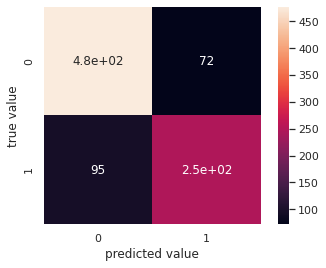

In [97]:
sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value')